In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# set to google drive location by default
file_root_path = '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial'

# if the files are in local devices, change the file_root_path to the local location


In [3]:
import argparse
import os
import sys
import torchvision
import torch
from torch.serialization import default_restore_location
from torch.distributions import Poisson
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches


import sys

# sys.path.append("/content/drive/MyDrive/Denoising Code/Denoising_Tutorial")

sys.path.append(file_root_path + "/electron-microscopy-denoising")

# sys.path.append('../')
import data
import models
import utils

In [4]:
# sys.path

In [5]:
checkpoint_path = file_root_path + '/electron-microscopy-denoising/checkpoints/unet-128-small.pt'

In [6]:
USE_CUDA = False
device = torch.device("cuda") if (
        torch.cuda.is_available() and USE_CUDA) else torch.device("cpu")

In [7]:
def load_model(checkpoint_path):
    state_dict = torch.load( checkpoint_path, map_location=lambda s,
                                l: default_restore_location(s,"cpu"))

    args = argparse.Namespace(
        **{**vars(state_dict["args"])})
    model = models.build_model(args).to(device)
    model.load_state_dict(state_dict["model"][0])
    model.eval()
    return model

In [8]:
net = load_model(checkpoint_path).to(device)
_ = net.eval()

In [9]:
x = torch.from_numpy(np.load('/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/electron-microscopy-denoising/images/real_data/00000.npy'))

In [10]:
noisy = x.to(device).unsqueeze(0).requires_grad_(True)
with torch.no_grad():
    denoised = net(noisy)

In [11]:
def visualize_denoising(list_of_images,
                        labels = ['clean', 'noisy', 'denoised'],
                        figsize = (15, 5),
                        vmax = 1.0, vmin = 0.0, psnr = True):
    fig, axes = plt.subplots(nrows=1, ncols=3, sharex = True, sharey = True, figsize = figsize)

    clean = list_of_images[0]
    for ax, image, label in zip(axes, list_of_images, labels):
        ax.imshow(image.data.cpu().numpy()[0, 0], cmap='gray', vmax=vmax, vmin = vmin)
        if psnr:
            psnr = utils.psnr(clean, image)
            ax.set_title(f"{label} {round(psnr, 2)}")

/usr/local/lib/python3.10/dist-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


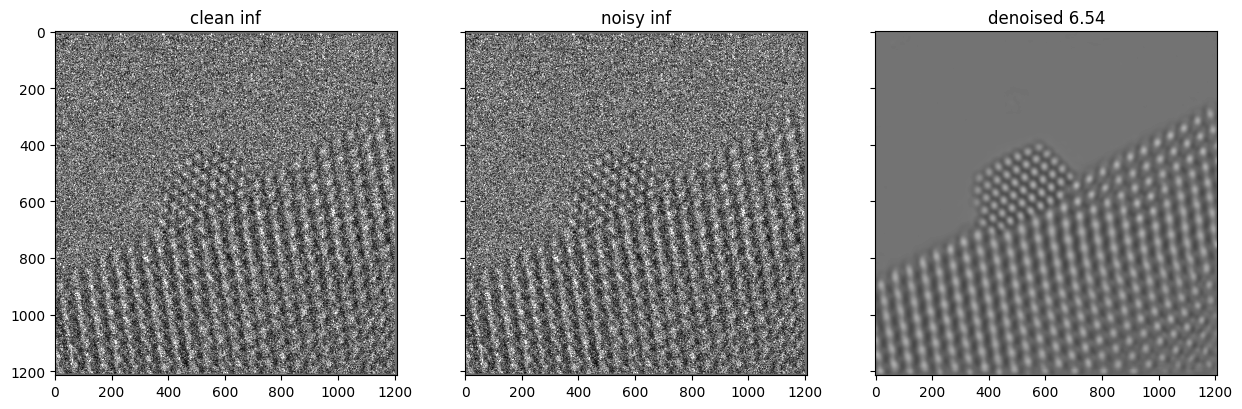

In [12]:
visualize_denoising([noisy, noisy, denoised], vmax = 1.0, vmin = 0)

In [13]:
pixels = [(np.random.randint(100, 600), np.random.randint(800, 1200)) for _ in range(2)]

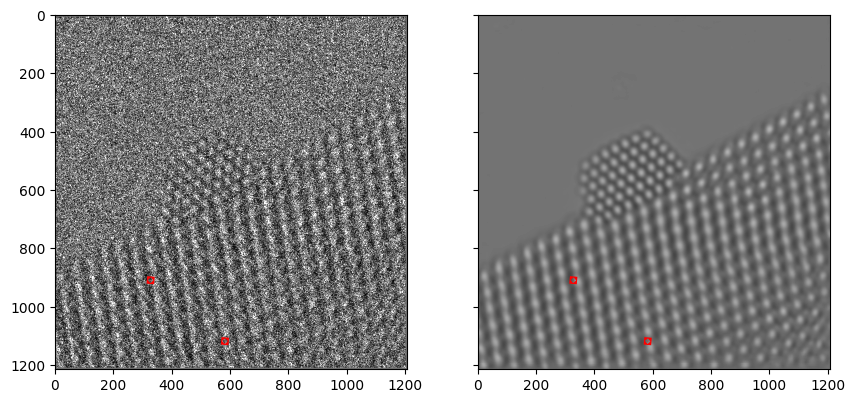

1 0.45018822 0.31503803 0.1351502


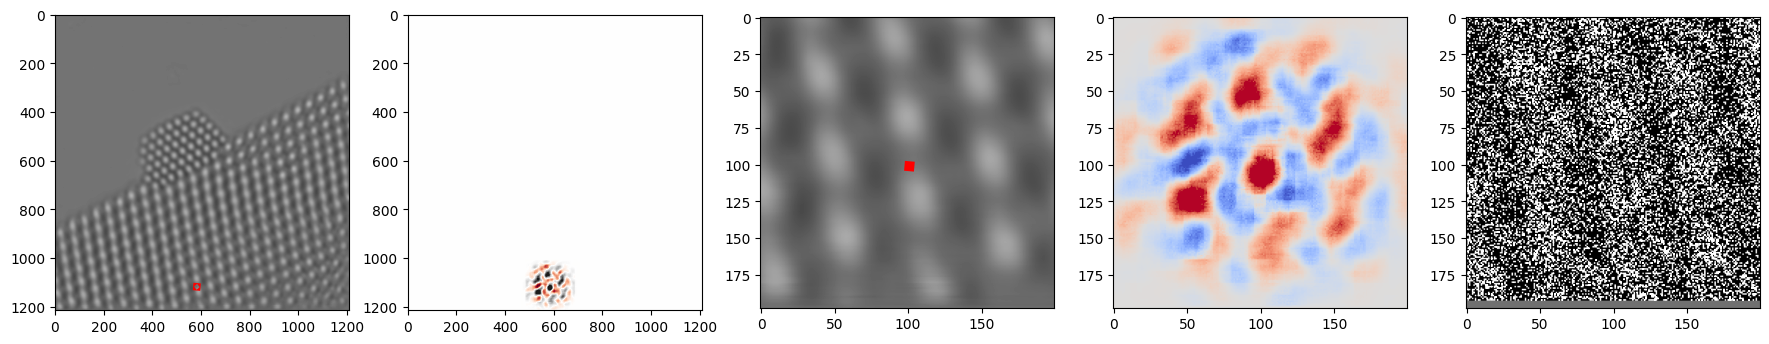

2 0.43757403 -0.07943753 0.5170116


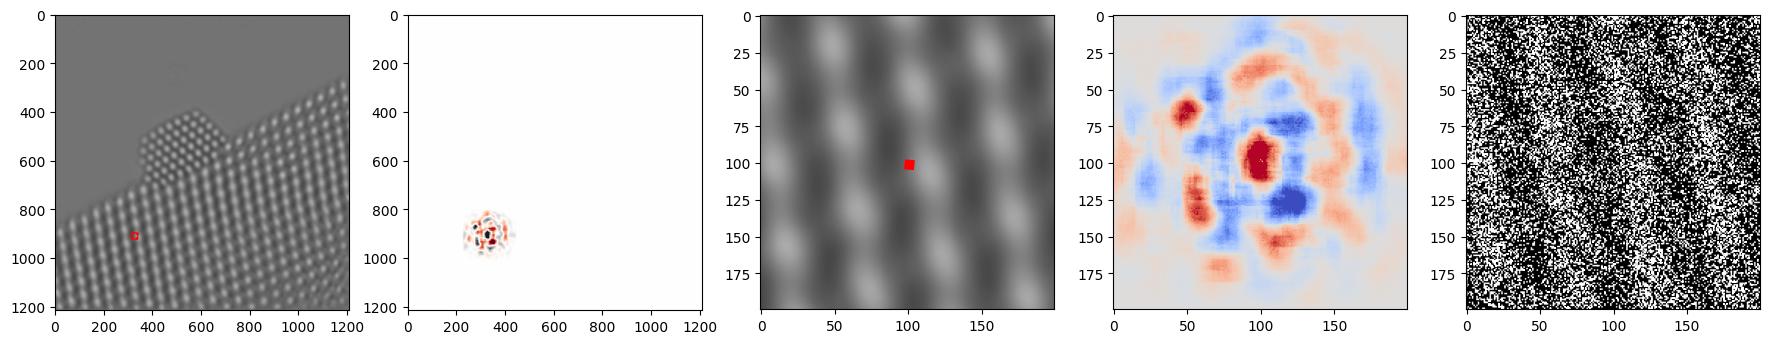

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex = True, sharey = True, figsize = (10, 5))

# plot noisy
axes[0].imshow(noisy[0, 0].cpu().data.numpy(), 'gray', vmin = 0, vmax = 1)

# denoise
noisy.requires_grad = True
denoised = net(noisy)

# plot denoised
axes[1].imshow(denoised[0, 0].cpu().data.numpy(), 'gray', vmin = 0, vmax = 1)

for j, (ix, iy) in enumerate(pixels):
    pa1 = patches.Rectangle((ix,iy), width=2, height=2, angle=5, edgecolor = [1,0,0], facecolor='red', lw=5)
    pa2 = patches.Rectangle((ix,iy), width=2, height=2, angle=5, edgecolor = [1,0,0], facecolor='red', lw=5)
    axes[0].add_patch(pa1)
    axes[1].add_patch(pa2)

plt.show()


width = 100
photo_num = 0
for j, (ix, iy) in enumerate(pixels):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize = (22, 6))

    im = axes[0].imshow(denoised[0, 0].cpu().data.numpy(), 'gray', vmin = 0, vmax = 1)


    filt = torch.autograd.grad(denoised[0,0,iy,ix], noisy, retain_graph=True)[0][0,0].cpu().data.numpy()

    photo_num += 1
    print(photo_num, denoised[0, 0, iy, ix].cpu().data.numpy(),
          np.sum(noisy.cpu().data.numpy()*filt),
          denoised[0, 0, iy, ix].cpu().data.numpy() - np.sum(noisy.cpu().data.numpy()*filt) )

    limit =  max(np.abs(np.min( filt)), np.abs(np.max( filt)))
    limit /= 2
    im = axes[1].imshow(filt, 'RdGy', vmin= -limit, vmax = limit)
    axes[2].imshow(denoised[0, 0, iy-width:iy+width, ix-width:ix+width].cpu().data.numpy(), 'gray', vmin = 0, vmax = 1)
    axes[3].imshow(filt[iy-width:iy+width, ix-width:ix+width], 'coolwarm' if True else 'gray', vmin= -limit, vmax = limit)
    axes[4].imshow(noisy[0, 0, iy-width:iy+width, ix-width:ix+width].cpu().data.numpy(), 'gray', vmin = 0, vmax = 1)

    pa1 = patches.Rectangle((ix,iy), width=2, height=2, angle=5, edgecolor = [1,0,0], facecolor='red', lw=5)
    axes[0].add_patch(pa1)

    pa2 = patches.Rectangle( ( width, width) ,
                    width=2, height=2, angle=5, edgecolor = [1,0,0], facecolor='red', lw=5)
    axes[2].add_patch(pa2)

    plt.show()

# Paper Plot

In [15]:
# ix, iy = pixels[8]
ix = 275
iy = 962
# ix = 535
# iy = 820
# ix = 450
# iy = 600
# ix = 300
# iy = 350

In [16]:
# ix_list = [275, 535, 450, 300]
# iy_list = [962, 820, 600, 350]
ix_list = [275, 535, 350, 360]
iy_list = [962, 820, 600, 560]

# ix_list = [275, 345, 350, 360]
# iy_list = [962, 600, 600, 560]

In [17]:
width = 100

In [18]:
linewidth = 3

In [19]:
xc = 0
yc = 0
idx = 1

In [20]:
figsize = (20, 20)

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
fig, axes = plt.subplots(nrows=4, ncols=4, sharex = False, sharey = False, figsize = figsize)

for i in range(4):
    ix = ix_list[i]
    iy = iy_list[i]



    axes[i][0].imshow(noisy[0,0, xc:xc+1200, yc:yc+1200].data.cpu().numpy(), cmap='gray', vmax=1.0, vmin = 0.0)
    pa1 = patches.Rectangle((ix,iy), width=2, height=2, angle=5, edgecolor = [1,0,0], facecolor='red', lw=5)
    axes[i][0].add_patch(pa1)
    rect1 = patches.Rectangle((ix-width,iy-width), width*2, width*2, linewidth= linewidth, edgecolor='r',facecolor='none')
    axes[i][0].add_patch(rect1)
    axes[i][0].axis('off')

    axes[i][1].imshow(denoised[0,0, :1200, :1200].data.cpu().numpy(), cmap='gray', vmax=1.0, vmin = 0.0)
    pa1 = patches.Rectangle((ix,iy), width=2, height=2, angle=5, edgecolor = [1,0,0], facecolor='red', lw=5)
    axes[i][1].add_patch(pa1)
    rect1 = patches.Rectangle((ix-width,iy-width), width*2, width*2, linewidth= linewidth, edgecolor='r',facecolor='none')
    axes[i][1].add_patch(rect1)
    axes[i][1].axis('off')

    axes[i][2].imshow(denoised[0,0, iy-width:iy+width, ix-width:ix+width].data.cpu().numpy(), cmap='gray', vmax=1.0, vmin = 0.0)
    pa1 = patches.Rectangle((width,width), width=2, height=2, angle=5, edgecolor = [1,0,0], facecolor='red', lw=5)
    axes[i][2].add_patch(pa1)
    rect1 = patches.Rectangle((0,0), width*2, width*2, linewidth= linewidth*3, edgecolor='r',facecolor='none')
    axes[i][2].add_patch(rect1)
    axes[i][2].axis('off')

    filt = torch.autograd.grad(denoised[0,0,iy,ix], noisy, retain_graph=True)[0][0,0].cpu().data.numpy()

    limit = np.max(np.abs(filt[iy-width:iy+width, ix-width:ix+width]))
    x = axes[i][3].imshow(filt[iy-width:iy+width, ix-width:ix+width], cmap='coolwarm', vmax = 0.8*limit, vmin=- 0.8* limit)
    axes[i][3].axis('off')
    x.set_clim(-0.0005, 0.0005)
    cbar = plt.colorbar(x, ax=axes[i][3])

        # Set the tick labels to scientific notation
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))  # You can adjust these limits as needed
    cbar.ax.yaxis.set_major_formatter(formatter)

    cbar.ax.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Adjust these values as needed


Output hidden; open in https://colab.research.google.com to view.

In [22]:
fig.savefig('comparison_plot_microscopy_gradient.pdf', bbox_inches='tight', dpi=300)